## Lecture 33 (optimization lecture 14): L2-regularized reconstruction

In [1]:
## MP 573 lecture 33
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd
import scipy.sparse as sparse
import skimage.data as skdata
import skimage.transform as transform


font = {'weight' : 'normal',
        'size'   : 18}

In [2]:
# Fitting 1/2[|| Px - d ||^2 + lambda ||WDx||^2]
# 1/2 || [P;sqrt(lambda)WD]x - [d;0] ||^2
# This function returns the value of our cost function
# Note the 1/2 factor, to keep consistent with the CG notation presented in HW2
def evalFun2(x,N,M,data,theta,lam,D,w):
    
    # Collect the relevant array sizes and reshape some arrays for convenience
    N1 = N[0]
    N2 = N[1]    
    M1 = M[0]
    M2 = M[1]
    data = np.reshape(data,(M1*M2,1))
    wvec = np.reshape(w,(N1*N2,1))
    
    # Calculate Px
    px1 = transform.radon(np.reshape(x,(N1,N2)), theta=theta, circle=False)
    px = np.reshape(px1,(M1*M2,1))

    # Calculate f = 1/2[|| Px - d ||^2 + lambda ||WDx||^2]
    f = 1/2*(la.norm(px-data)**2 + lam*la.norm(wvec*(D.dot(np.reshape(x,(N1*N2,1)))))**2)
      
    return f



In [3]:
# Fitting 1/2[|| Px - d ||^2 + lambda ||WDx||^2]
# 1/2 || [P;sqrt(lambda)WD]x - [d;0] ||^2
# This function returns the value and gradient of our cost function
# Note the 1/2 factor, to keep consistent with the CG notation presented in HW2
def evalGradients2(x,N,M,data,theta,lam,D,w):
    
    # Collect the relevant array sizes and reshape some arrays for convenience
    N1 = N[0]
    N2 = N[1]
    M1 = M[0]
    M2 = M[1]
    data = np.reshape(data,(M1*M2,1))
    wvec = np.reshape(w,(N1*N2,1))
    
    # Calculate Px
    px1 = transform.radon(np.reshape(x,(N1,N2)), theta=theta, circle=False)
    px = np.reshape(px1,(M1*M2,1))
    
    # Calculate f = 1/2[|| Px - d ||^2 + lambda ||WDx||^2]
    f = 1/2*(la.norm(px-data)**2 + lam*la.norm(wvec*(D.dot(np.reshape(x,(N1*N2,1)))))**2)
    
    # Calculate the gradient g (a vector)
    phpx = 2*M2/np.pi*transform.iradon(px1, theta=theta, circle=False, filter_name=None, interpolation='cubic')    
    phd = 2*M2/np.pi*transform.iradon(np.reshape(data,(M1,M2)), theta=theta, circle=False, filter_name=None, interpolation='cubic')
    temp = wvec*wvec*(D.dot(np.reshape(x,(N1*N2,1))))
    g = np.reshape(phpx,(N1*N2,1)) + lam*(D.T).dot(temp) - np.reshape(phd,(N1*N2,1))
        
    return f,g


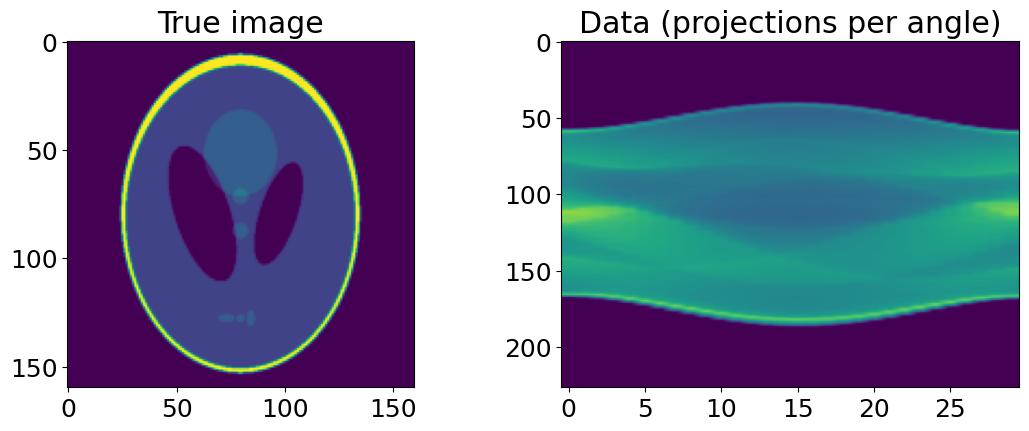

In [29]:
# Similarly to homework 6, WHICH_PROBLEM indicates:
# 1: LS without regularization
# 2: LS with smoothness regularization
# 3: LS with anatomically-weighted smoothness regularization
WHICH_PROBLEM = 1 

#Here's the data
data_dir = pjoin('.', 'data')
xtrue = skdata.shepp_logan_phantom()
xtrue = transform.rescale(xtrue, scale=0.4)
N1,N2 = xtrue.shape
theta = np.linspace(0., 180., 30, endpoint=False)
data = transform.radon(xtrue, theta=theta, circle=False)
M1,M2 = data.shape
datavec = np.reshape(data,(M1*M2))


# Here's a finite-difference taking matrix
I = np.eye(N1)
D = 2*I - np.roll(I,-1,axis=1) - np.roll(I,1,axis=1)
D = sparse.csr_matrix(D) 
I = sparse.eye(N1)
D2 = sparse.kron(D,I) + sparse.kron(I,D)

if WHICH_PROBLEM == 1:
    w = np.ones((N1,N2))
    lam = 0
elif WHICH_PROBLEM == 2:
    w = np.ones((N1,N2))    
    lam = 1E5 # Example: can try 1E2, 1E5
else: # if WHICH_PROBLEM == 3:
    Dx = np.abs(D2.dot(np.reshape(xtrue,(N1*N2,1))))
    Dx = Dx/np.max(Dx)
    w = 1-Dx
    w[w<0.95] = 0.0
    lam = 1E3

niter = 30 # Number of overall descent iterations
niterGS = 20 # Number of golden section search iterations within each SD iteration
INIT_FBP = 1 # Initialize iterative algorithms with the FBP recon

wvec = np.reshape(w,(N1*N2,1))

#plt.figure(figsize=(4,4))
#imgplot = plt.imshow(abs(np.reshape(xtrue,(N1,N2))),cmap='gray',vmin=0,vmax=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.set_title("True image")
ax1.imshow(xtrue, vmin=0, vmax=1)
ax2.set_title("Data (projections per angle)")
ax2.imshow(data, vmin=0, vmax=50, aspect='auto');


FBP: cost function = 
102526.99343443871


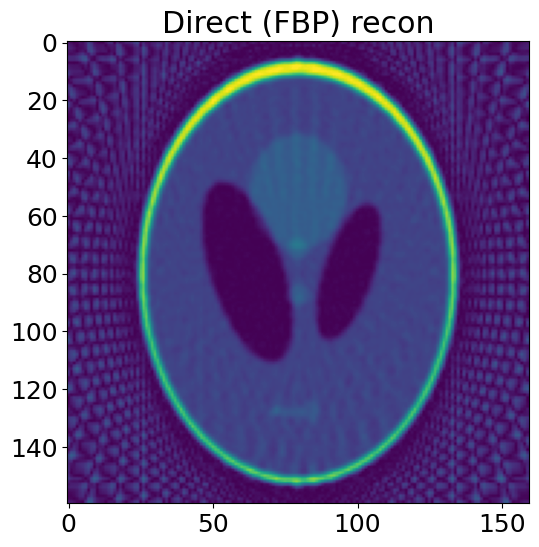

In [30]:
# Filtered backprojection
x1 = transform.iradon(data, theta=theta, circle=False, filter_name='hamming')

plt.figure(figsize=(6,6))
imgplot = plt.imshow(abs(np.reshape(x1,(N1,N2))),vmin=0,vmax=1)
plt.rc('font', **font)
plt.title('Direct (FBP) recon')

# We can evaluate our cost function at the FPB solution
f,g = evalGradients2(x1,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
print('FBP: cost function = ')
print(f)

Algorithm: Steepest Descent
Done, cost function = 
6894.690411616659


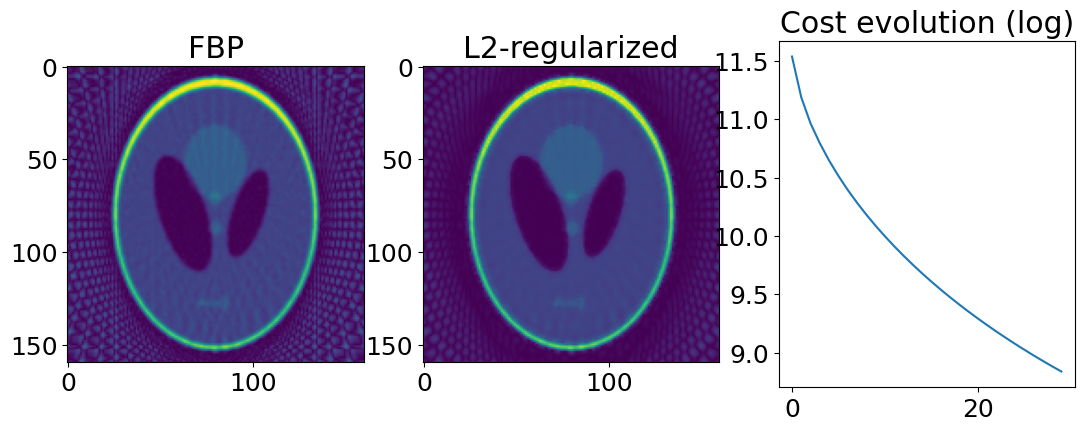

In [31]:
print('Algorithm: Steepest Descent')
if INIT_FBP>0:
    x = x1
else:
    x = 0*x1

allfSD = np.zeros(niter)

x = np.reshape(x,(N1*N2,1))
for k in range(0,niter): # Main iterations: find g and descend along SD direction (-g)
    f,g = evalGradients2(x,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
    

    if la.norm(g)>0.000001:
        d = -g/np.max(abs(g)) # Normalizing gradient to get reasonable step size
        a0 = 0
        b0 = 1
        for kg in range(0,niterGS): # Golden section search within each iteration
            a1 = x + d*a0 + d*(b0-a0)*0.382;
            b1 = x + d*a0 + d*(b0-a0)*0.618;
            fa1 = evalFun2(a1,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
            fb1 = evalFun2(b1,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
            if fb1<fa1:
                a0 = a0 + 0.382*(b0-a0);
            else:
                b0 = a0 + 0.618*(b0-a0);
              
        alpha = (a0+b0)/2;
        allfSD[k] = f
        x = x +alpha*d;

# Collect output and display results        
xSD = np.reshape(x,(N1,N2))        
print('Done, cost function = ')
print(f)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.set_title("FBP")
ax1.imshow(abs(np.reshape(x1,(N1,N2))), vmin=0, vmax=1)
ax2.set_title("L2-optimization (SD)")
ax2.imshow(abs(xSD), vmin=0, vmax=1)
ax3.set_title("Cost evolution (log)")
ax3.plot(np.log(allfSD));

Algorithm: Conjugate Gradients
Done, cost function = 
666.0539858172741


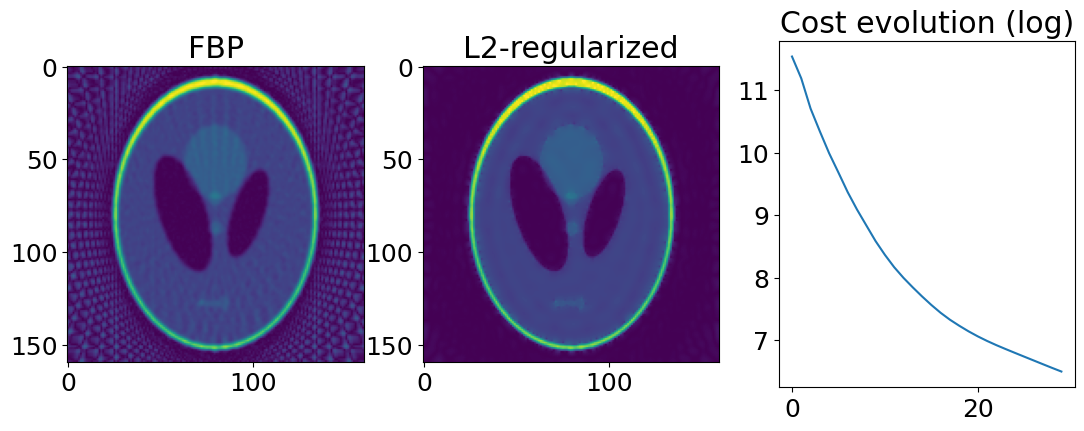

In [32]:
print('Algorithm: Conjugate Gradients')
if INIT_FBP>0:
    x = x1
else:
    x = 0*x1
  
    
x = np.reshape(x,(N1*N2,1))
    
allfCG = np.zeros(niter)

f,g = evalGradients2(x,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
allfCG[0] = f 
if la.norm(g)>0.000001:
    d = -g
    k=1;
    while k < niter: # CG Iterations
        pd = transform.radon(np.reshape(d,(N1,N2)), theta=theta, circle=False)
        phpd = 2*M2/np.pi*transform.iradon(pd, theta=theta, circle=False, filter_name=None, interpolation='cubic')
        temp = wvec*wvec*(D2.dot(np.reshape(d,(N1*N2,1))))
        Qd = np.reshape(phpd,(N1*N2,1)) + lam*(D2.T).dot(temp)
        a = -((np.conj(g.T)).dot(d))/(np.conj(d.T).dot(Qd));
        xold = x
        x = x + a*d;
        f,g = evalGradients2(x,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
        allfCG[k] = f

        if la.norm(g)>0.000001:
            b = (np.conj(g.T).dot(Qd))/(np.conj(d.T).dot(Qd));
            d = -g + b*d;
        else:
            k = niter

        # If things go wrong, run for safety
#        if  allfCG[k] > allfCG[k-1]:
#            allfCG[k] = allfCG[k-1]
#            x = xold;
#            f,g = evalGradients2(x,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
#            d = -g
            
        k = k+1

# Collect output and display results        
xCG = np.reshape(x,(N1,N2))        
print('Done, cost function = ')
print(f)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.set_title("FBP")
ax1.imshow(abs(np.reshape(x1,(N1,N2))), vmin=0, vmax=1)
ax2.set_title("L2-optimization (CG)")
ax2.imshow(abs(xCG), vmin=0, vmax=1)
ax3.set_title("Cost evolution (log)")
ax3.plot(np.log(allfCG));

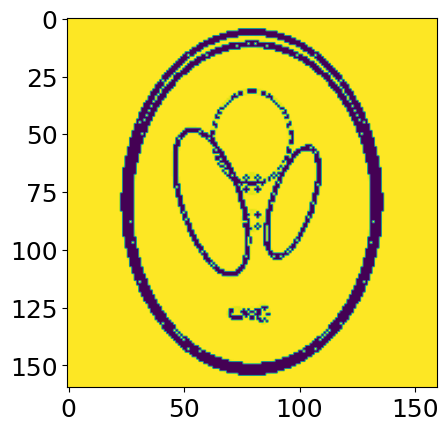

In [33]:
# Let's show the weights used in this reconstruction
plt.imshow(abs(np.reshape(w,(N1,N2))), vmin=0, vmax=1);